In [25]:
from transformers import (VisionEncoderDecoderModel, ViTFeatureExtractor, PreTrainedTokenizerFast)
from transformers import Trainer, TrainingArguments
from transformers import BertConfig, ViTConfig, VisionEncoderDecoderConfig
from transformers import AdamW
import torch
import numpy as np
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms

In [2]:
humors_info = pd.read_csv('./humor_data.csv')
train_data = humors_info.iloc[:100]
valid_data = humors_info.iloc[100:200]

In [3]:
valid_data.head()

,img_urls,labels,img_paths
100,https://d2dcan0armyq93.cloudfront.net/photo/od...,ボルトにナンパされちゃてさーで聞いてよ、あいつ夜も世界最速。早いのは足だけにしろっての、足臭...,./imgs/100.jpg
101,https://d2dcan0armyq93.cloudfront.net/photo/od...,「いつもメントス食べてる爺さんに飲ませてみましょ、知らなそうだし」「ヒュ～、鬼畜ぅ！」,./imgs/101.jpg
102,https://d13n9ry8xcpemi.cloudfront.net/photo/od...,他人の喧嘩を間近で見る癖がある。,./imgs/102.jpg
103,https://d2dcan0armyq93.cloudfront.net/photo/od...,完全にテストを諦めた,./imgs/103.jpg
104,https://d2dcan0armyq93.cloudfront.net/photo/od...,「パパ、ママは？」「パパ、ママは？」「パパ、ママは？」「・・・頂こう」,./imgs/104.jpg


In [4]:
train_labels = train_data['labels']
valid_labels = valid_data['labels']
#data.head()


In [5]:
class HumorDataset(Dataset):
    def __init__(self,data, tokenizer) -> None:
        super().__init__()
        self.data = data
        self.image_datas = []
        self.image_list = self.data['img_paths'].tolist()
        self.label_list = self.data['labels'].tolist()
        self.bos = '<s>'
        self.eos = '</s>'
        
        for i in range(len(self.data)):
            image = Image.open(self.image_list[i]).convert("RGB")
            image_tensor = np.array(image)
            pixel_values = feature_extractor(image_tensor, return_tensors="pt").pixel_values
            self.image_datas.append(pixel_values)

        labels_strings = []
        for i in range(len(self.data)):
            text = self.label_list[i]
            labels_strings.append(text)
        self.labels = tokenizer(labels_strings, return_tensors="pt",padding=True , truncation=True).input_ids

    def __getitem__(self, index: int):
        return self.image_datas[index], self.labels[index]
    def __len__(self):
        return len(self.data)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# gpu 사용
decoder_model_name_or_path = 'skt/kogpt2-base-v2'
#decoder_model_name_or_path = 'klue/bert-base'
encoder_model_name_or_path = 'google/vit-base-patch16-224-in21k'

feature_extractor = ViTFeatureExtractor.from_pretrained(encoder_model_name_or_path)
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model_name_or_path, decoder_model_name_or_path)
# encoder, extractor -> vit
model.to(device)
print("Model loaded")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['transformer.h.11.crossattention.c_attn.weight', 'transformer.h.2.crossattention.bias', 'transformer.h.8.crossattention.q_attn.weight', 'transformer.h.11.ln_cross_attn.weight', 'transformer.h.9.crossattention.q_attn.weight', 'transformer.h.10.ln_cross_attn.weight', 'transformer.h.6.crossattention.c_attn.weight', 'transformer.h.6.crossattention.c_proj.bias', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.3.crossattention.c_proj.bias', 'transformer.h.11.crossattention.q_attn.weight', 'transformer.h.4.crossattention.q_attn.weight', 'transformer.h.6.ln_cross_attn.weight', 'transformer.h.5.crossattention.c_proj.bias', 'transformer.h.8.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.4.crossattention.c_attn.weight', 'transformer.h.2.crossattention.q_attn.weight', 'tra

Model loaded


In [7]:
tokenizer = PreTrainedTokenizerFast.from_pretrained(decoder_model_name_or_path, bos_token='<s>', 
eos_token='</s>', unk_token='<unk>',pad_token='<pad>', mask_token='<mask>')
# decoder, tokenizer -> gpt2

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [8]:
train_dataset = HumorDataset(train_data,tokenizer)
valid_dataset = HumorDataset(valid_data,tokenizer)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [9]:
def collate_fn(samples):
    collate_img = []
    collate_label = []
    tensor_size = samples[0][0].size()

    for batch_idx, sample in enumerate(samples):
        collate_label.append(sample[1])
        collate_img.append(sample[0])
    return {'pixel_values' : torch.cat(collate_img,0),
    'labels':torch.stack(collate_label,0)}

In [10]:
#image
model.config.decoder_start_token_id = 0
model.config.pad_token_id = 3
model.config.vocab_size = model.config.decoder.vocab_size

In [11]:
train_loader = DataLoader(train_dataset, batch_size=4,collate_fn=collate_fn, shuffle=True)

In [12]:
test_train_loader = next(iter(train_loader))

In [13]:
print(test_train_loader['pixel_values'].shape)
print(test_train_loader['labels'].shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 61])


In [15]:
model.train()

train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn,shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, collate_fn=collate_fn,shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in tqdm(train_loader):
        optim.zero_grad()
        batch_pixel_values, batch_labels = batch['pixel_values'], batch['labels']
        outputs = model(pixel_values=batch_pixel_values.to(device), labels=batch_labels.to(device))
        loss = outputs.loss
        loss.backward()
        optim.step()



100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


In [16]:
valid_batch = next(iter(valid_loader))

In [21]:
generated_ids = model.generate(valid_batch['pixel_values'].to(device))
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

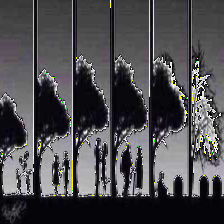

In [31]:
img = valid_batch['pixel_values'][3]
transforms.ToPILImage()(img)